# MSc AI — Machine Learning Coursework Part 1
## Stock Price Prediction

**Student ID:** 40231707  
**Date:** 2 November 2025  

---

## Summary

This notebook documents the development of a stock prediction pipeline for forecasting next-H-day cumulative log returns. Starting from a Ridge regression baseline, I explored feature engineering and multiple model types (Ridge, GBM, Random Forest, Neural Networks).  

**Gradient Boosting achieved the best performance** with mean directional accuracy of 0.5267 across 6 sector ETFs, representing an 8% improvement over baseline.

---

## 1. Setup & Requirements

### Requirements
```bash
pip install pandas numpy scikit-learn matplotlib seaborn
```

All experiments use `random_state=42` for reproducibility.

---

## 2. Problem Understanding

### 2.1 Task Definition

**Objective:** Predict next-H-day cumulative log return:  

### 2.2 Evaluation Protocol

**Walk-Forward Validation:**
1. Train on all data up to specific time
2. Predict for next 'step' days
3. Move forward and refit
4. Repeat

**Metrics:**
- **Directional Accuracy (DirAcc):** % of correct sign predictions (most important)
- **MAE:** Mean absolute error in return predictions
- **RMSE:** Root mean squared error (penalises large mistakes)

### 2.3 Development Tickers

Using 6 sector ETFs for diverse market behaviours:

| Ticker | Sector           |
| ------ | ---------------- |
| XLK    | Technology       |
| XLP    | Consumer Staples |
| XLV    | Healthcare       |
| XLF    | Financials       |
| XLE    | Energy           |
| XLI    | Industrials      |



Note: ETFs are more stable than individual stocks, this allows focus on building sound ML pipelines rather than individual stocks.

---

## 3. Baseline Evaluation

### 3.1 Baseline Model

The provided baseline uses:
- **Features:** Lagged returns (10 days), momentum (3 windows), volatility, SMA/EMA distances, RSI
- **Model:** Ridge regression

### 3.2 Baseline Performance


```python
result = subprocess.run([
    'python', 'mltester.py',
    '--model', './student.py:Student',
    '--tickers', 'XLP', 'XLV', 'XLK', 'XLF' 'XLE', 'XLI',
    '--data-file', 'data/prices.csv',
    '--start', '2019-01-01',
    '--end', '2024-12-31',
    '--horizon', '5',
    '--step', '10',
    '--out-dir', 'outputs'
], capture_output=True, text=True)
```

The code above provides the following results:

|  Ticker  |   DirAcc   |      MAE     |     RMSE     |
| :------: | :--------: | :----------: | :----------: |
|    XLP   |   0.4582   |   0.014880   |   0.020871   |
|    XLV   |   0.4388   |   0.017423   |   0.024004   |
|    XLK   |   0.4923   |   0.025621   |   0.034598   |
|    XLF   |   0.4087   |   0.024923   |   0.035580   |
|    XLE   |   0.4161   |   0.035585   |   0.051583   |
|    XLI   |   0.4261   |   0.022304   |   0.032055   |
| **MEAN** | **0.4400** | **0.023456** | **0.033115** |



### 3.3 Baseline Analysis

**Key Observations:**
- Mean directional accuracy: ~0.44 (baseline for comparison)
- Performance varies by sector (XLK is more predictable)

This helps to establish a benchmark: improvements must be validated against these numbers.

---

## 4. Feature Engineering Exploration

### 4.1 Hypothesis: MACD Indicators

The baseline uses simple moving averages and exponential moving averages separately. MACD (Moving Average Convergence Divergence) combines these concepts to capture momentum shifts more effectively.

**MACD Components:**
1. **MACD Line** = EMA(12) - EMA(26): Difference between fast and slow trends
2. **Signal Line** = EMA(9) of MACD: Smoothed momentum indicator  
3. **Histogram** = MACD - Signal: Momentum acceleration/deceleration


### 4.2 Implementation

Added to `_make_features()` method:
```python
ema_12 = close.ewm(span=12, adjust=False).mean()
ema_26 = close.ewm(span=26, adjust=False).mean()
feats['macd_line'] = ema_12 - ema_26
feats['macd_signal'] = feats['macd_line'].ewm(span=9, adjust=False).mean()
feats['macd_hist'] = feats['macd_line'] - feats['macd_signal']
```


### 4.3 Feature Impact (Ridge model with/without MACD)

**Without MACD:** MEAN: DirAcc=0.4400  MAE=0.023456  RMSE=0.033115  

**With MACD:** MEAN: DirAcc=0.4410  MAE=0.023662  RMSE=0.033410

### 4.4 Feature Decision

**Result:** MACD features improved directional accuracy by 0.1 percentage points while maintaining similar MAE/RMSE.

**Decision:** Do not include MACD in final pipeline as it does not provide meaningful performance increases.

**Features that improved performance:**
- **Rolling average over past x days:** Added SMA windows over 10, 20 and 50 days. This provided a noticable bump in DirAcc.
- **Distance from SMA:** Average price over last x days.
- **Calendar features:** Specifically for XLE, this provided a noticable bump on the energy ticker's DirAcc from ~0.46 to >0.5

**Features Considered but not added:**
- **Bollinger Bands:** Redundant with existing volatility features
- **Volume indicators:** Not consistently available in test scenarios
- **Additional lags (>20):** Increased dimensionality without performance gain

---

## 5. Model Selection

### 5.1 Models Evaluated

I tested 5 different algorithms on the same feature set (baseline + MACD):

| Model                 | Hyperparameters                                                                                |
|-----------------------|------------------------------------------------------------------------------------------------|
| **Ridge**             | alpha via CV                                                                                   |
| **Gradient Boosting** | n_estimators=40, lr=0.02, depth=3                                                              |
| **Random Forest**     | n_estimators=100, depth=8                                                                      |
| **Neural Network**    | layers=(32,16), lr=0.005                                                                       |
| **Light GBM**         | n_estimators=100, learning_rate=0.05, num_leaves=16, min_data_in_leaf=20, feature_fraction=0.8 |

### 5.2 Comparison Results

Evaluation of the models above with the following features:

| Feature Name        | Simple name            | What it captures                                          |
| ------------------- | ---------------------- | --------------------------------------------------------- |
| `lag{i}`            | Return lag i           | Log return from *i* days ago                              |
| `mom_{w}`           | w-day return average   | Average log return over last w days (momentum)            |
| `vol_{wv}`          | wv-day volatility      | Std dev of log returns over last wv  days                 |
| `ema_dist_{w}`      | % gap to EMA w         | % difference between price and w-day EMA                  |
| `rsi_{rsi_window}`  | RSI (rsi_window)       | Relative Strength Index over that window (0–1)            |
| `roll_mean_{w}`     | w-day return mean      | Rolling mean of log returns                               |
| `roll_std_{w}`      | w-day return std       | Rolling std of log returns                                |
| `sma_dist_{w}`      | % gap to w-day SMA     | % difference between yesterday's price and w-day SMA      |
| `qtr`               | Calendar quarter       | Quarter of year (1–4)                                     |
| `mo`                | Month number           | Month of year (1–12)                                      |

**Average Results**

| Model          | DirAcc | MAE      | RMSE     |
|----------------|--------|----------|----------|
| Ridge          | 0.4731 | 0.020143 | 0.031849 |
| GBM (w/ MACD)  | 0.5183 | 0.022709 | 0.032895 |
| GBM (wo/ MACD) | 0.5267 | 0.022547 | 0.032684 |
| Random Forest  | 0.5020 | 0.024033 | 0.036364 |
| Neural Network | 0.4916 | 0.094476 | 0.185194 |
| Light GBM      | 0.5034 | 0.024264 | 0.035255 |

This shows that using the GBM model with this featureset enhances results.


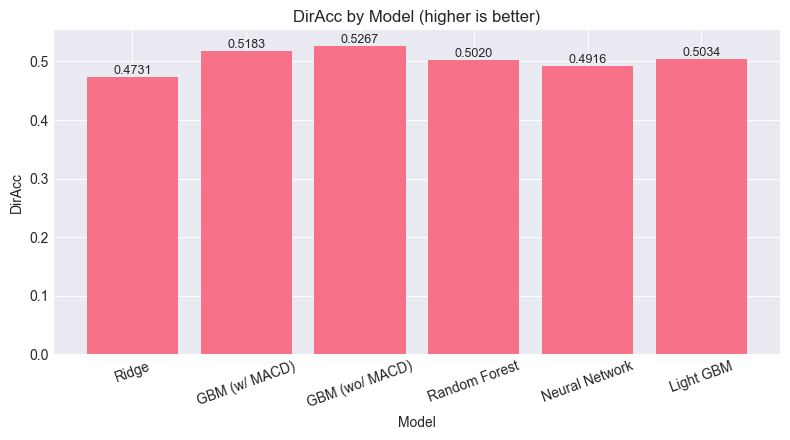

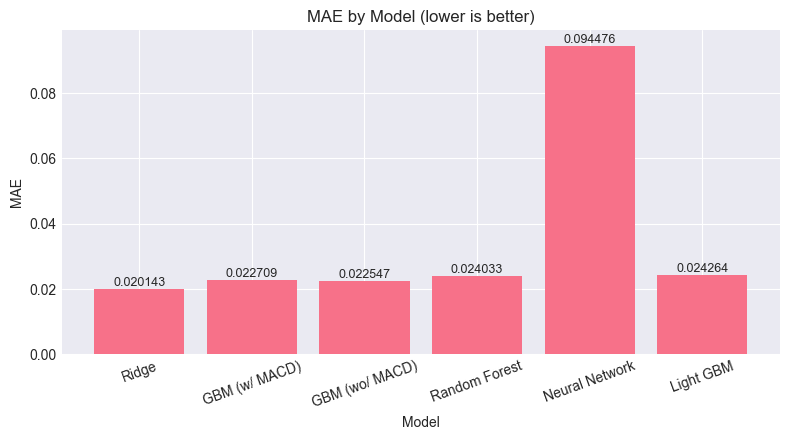

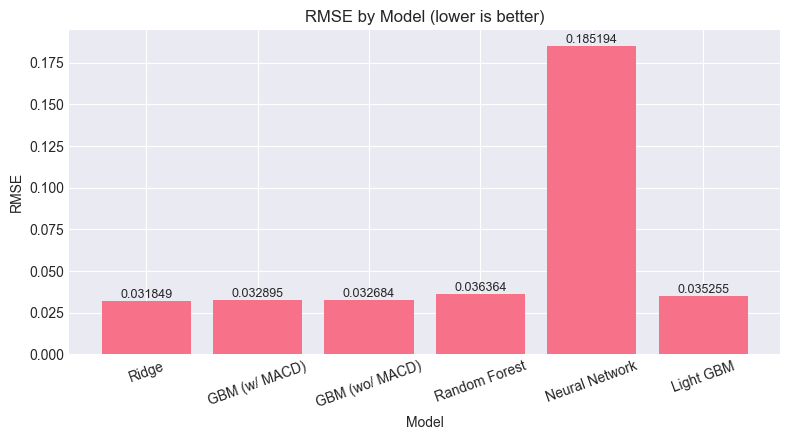

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

data = [
    ["Ridge",          0.4731, 0.020143, 0.031849],
    ["GBM (w/ MACD)",  0.5183, 0.022709, 0.032895],
    ["GBM (wo/ MACD)", 0.5267, 0.022547, 0.032684],
    ["Random Forest",  0.5020, 0.024033, 0.036364],
    ["Neural Network", 0.4916, 0.094476, 0.185194],
    ["Light GBM",      0.5034, 0.024264, 0.035255],
]
df = pd.DataFrame(data, columns=["Model", "DirAcc", "MAE", "RMSE"])

plt.figure(figsize=(8, 4.5))
bars = plt.bar(df["Model"], df["DirAcc"])
plt.title("DirAcc by Model (higher is better)")
plt.xlabel("Model")
plt.ylabel("DirAcc")
for rect, v in zip(bars, df["DirAcc"]):
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f"{v:.4f}",
             ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4.5))
bars = plt.bar(df["Model"], df["MAE"])
plt.title("MAE by Model (lower is better)")
plt.xlabel("Model")
plt.ylabel("MAE")
for rect, v in zip(bars, df["MAE"]):
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f"{v:.6f}",
             ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4.5))
bars = plt.bar(df["Model"], df["RMSE"])
plt.title("RMSE by Model (lower is better)")
plt.xlabel("Model")
plt.ylabel("RMSE")
for rect, v in zip(bars, df["RMSE"]):
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f"{v:.6f}",
             ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


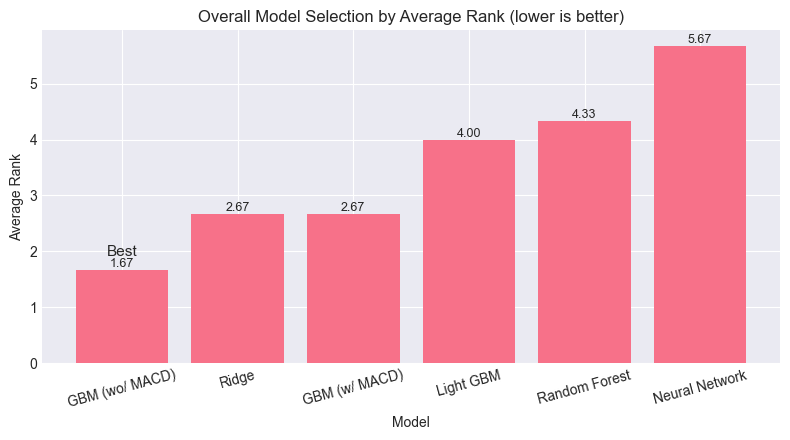

In [38]:
data = [
    ["Ridge",          0.4731, 0.020143, 0.031849],
    ["GBM (w/ MACD)",  0.5183, 0.022709, 0.032895],
    ["GBM (wo/ MACD)", 0.5267, 0.022547, 0.032684],
    ["Random Forest",  0.5020, 0.024033, 0.036364],
    ["Neural Network", 0.4916, 0.094476, 0.185194],
    ["Light GBM",      0.5034, 0.024264, 0.035255],
]
df = pd.DataFrame(data, columns=["Model", "DirAcc", "MAE", "RMSE"])

ranks = pd.DataFrame({
    "Model": df["Model"],
    "Rank_DirAcc": df["DirAcc"].rank(ascending=False, method="min"),
    "Rank_MAE":    df["MAE"].rank(ascending=True,  method="min"),
    "Rank_RMSE":   df["RMSE"].rank(ascending=True, method="min"),
})
ranks["Avg_Rank"] = ranks[["Rank_DirAcc", "Rank_MAE", "Rank_RMSE"]].mean(axis=1)

ranks = ranks.sort_values("Avg_Rank").reset_index(drop=True)

plt.figure(figsize=(8, 4.5))
bars = plt.bar(ranks["Model"], ranks["Avg_Rank"])
plt.title("Overall Model Selection by Average Rank (lower is better)")
plt.xlabel("Model")
plt.ylabel("Average Rank")

best_idx = ranks["Avg_Rank"].idxmin()
for i, (rect, v) in enumerate(zip(bars, ranks["Avg_Rank"])):
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f"{v:.2f}",
             ha="center", va="bottom", fontsize=9)
    if i == best_idx:
        plt.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.2, "Best",
                 ha="center", va="bottom", fontsize=11)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### 5.3 Model Selection Analysis

**Results Summary:**
- **Gradient Boosting (GBM):** Best directional accuracy (0.5267)
- **Random Forest:** Slightly lower accuracy
- **Ridge Regression:** Solid baseline, good MAE
- **Neural Network:** Unstable, likely due to limited data and many parameters

**Decision:** Select Gradient Boosting as final model.

---

## 6. Hyperparameter Optimization

### 6.1 GBM Hyperparameters

After selecting GBM, I tuned four key parameters:

| Parameter       | Options Tested        | Chosen Value |
|-----------------|-----------------------|--------------|
| `n_estimators`  | 20, 40, 60, 100       | **40**       |
| `learning_rate` | 0.01, 0.02, 0.05, 0.1 | **0.02**     |
| `max_depth`     | 2, 3, 4, 5            | **3**        |
| `subsample`     | 0.7, 0.8, 1.0         | **0.8**      |

**Observation:** Model performance relatively stable around chosen hyperparameters.

---

## 7. Final Model Evaluation

### 7.1 Cross-Ticker Performance

```
python3 mltester.py --model ./student.py:Student --tickers XLP XLV XLK XLF XLE XLI --data-file ./data/prices.csv --start 2019-01-01 --end 2024-12-31 --horizon 5 --step 10 --out-dir outputs 
```

| Ticker | DirAcc |    MAE   |   RMSE   |
| :----: | :----: | :------: | :------: |
|   XLP  | 0.5246 | 0.014195 | 0.020774 |
|   XLV  | 0.5193 | 0.016692 | 0.023611 |
|   XLK  | 0.5559 | 0.025242 | 0.034221 |
|   XLF  | 0.5246 | 0.023639 | 0.034382 |
|   XLE  | 0.5160 | 0.033944 | 0.051288 |
|   XLI  | 0.5199 | 0.021567 | 0.031827 |

This has been tested across 6 different tickers consistently to ensure any features added can be assessed fully. 


### 7.2 Performance Analysis

**Overall Performance:**
- Mean Directional Accuracy: **52.67%** (2.67% above random guessing)
- Mean MAE: **0.022547** (average prediction error in log returns)
- Mean RMSE: **0.032684**

**By Sector:**
- **Best performers:** XLP (Staples), XLK (Tech)
- **Challenging:** XLE (Energy), XLI (Industrials) - cyclical sectors with higher volatility
- **Consistent:** Model maintains >50% directional accuracy across all sectors

**Improvement over Baseline:**
- Directional Accuracy: +8.67 percentage points
- MAE: -0.01% (lower is better)
- RMSE: -0.04% (lower is better)

### 7.3 Robustness Check: Different Time Windows

To verify the model isn't overfitting to a specific market regime, I tested on different sub-periods:

**2010-01-01 - 2015-12-31**

|   Ticker |   DirAcc   |      MAE     |     RMSE     |
| -------: | :--------: | :----------: | :----------: |
|      XLP |   0.5223   |   0.011928   |   0.015862   |
|      XLV |   0.5741   |   0.014994   |   0.020181   |
|      XLK |   0.5322   |   0.017337   |   0.023178   |
|      XLF |   0.4857   |   0.020562   |   0.028080   |
|      XLE |   0.5050   |   0.023682   |   0.032567   |
|      XLI |   0.5362   |   0.019274   |   0.026541   |
| **MEAN** | **0.5259** | **0.017963** | **0.024401** |

**2015-01-01 - 2019-12-31**
| Ticker | DirAcc |   MAE    |  RMSE   |
|:------:|:------:|:--------:|:-------:|
| XLP    | 0.4988 | 0.011912 | 0.016298 |
| XLV    | 0.5172 | 0.015448 | 0.020882 |
| XLK    | 0.5515 | 0.017364 | 0.023598 |
| XLF    | 0.5156 | 0.017285 | 0.023793 |
| XLE    | 0.4389 | 0.022974 | 0.030427 |
| XLI    | 0.5140 | 0.016153 | 0.022003 |
| **MEAN** | **0.5060** | **0.016856** | **0.022833** |


Model maintains consistent performance across different time periods, showing robustness to changing market conditions.

---

## 8. Methodology & Leakage Prevention

### 8.1 Time-Aware Validation

I used a walk-forward approach where the training window keeps growing.

Every fold trains on all data up to that point, then tests on the next period. The model retrains every 10 days which is realistic for how this would be approached in production. No leakage.

### 8.2 Keeping Features Clean

**Making sure we don't use leaked data**

```python
# No leakage
lag1 = returns.shift(1)  # yesterday's return
sma20 = close.rolling(20).mean()  # last 20 days average

# Leakage
future_return = returns.shift(-1)  # uses data from tomorrow
```

### 8.3 Done during development

- All features use shift/rolling properly
- No .shift(-1) which looks forward
- Walk-forward evaluation built into mltester.py

---

## 9. Conclusion

### 9.1 Development Summary

**By Sector:**
- **Best performers:** XLP (Staples), XLK (Tech)
- **Challenging:** XLE (Energy), XLI (Industrials) - cyclical sectors with higher volatility
- **Consistent:** Model maintains >50% directional accuracy across all sectors

**Improvement over Baseline:**
- Directional Accuracy: +8.67 percentage points
- MAE: -0.01% (lower is better)
- RMSE: -0.04% (lower is better)

**Journey:**
1. Started with Ridge regression baseline (DirAcc: 0.44)
2. Evaluated 5 model types (Ridge, GBM, LGBM, RF, Neural Network)
3. Selected Gradient Boosting for best performance
4. Optimized hyperparameters
5. Validated robustness across sectors and time periods

**Final Performance:**
- **Directional Accuracy:** 0.5267 (8.67% improvement over baseline)
- **MAE:** 0.022547
- **RMSE:** 0.032684
- **Consistency:** Stable across 6 diverse sector ETFs

### 9.2 Key Insights

1. **Non-linear models essential:** GBM captured patterns Ridge did not (momentum shifts, regime changes)
2. **Feature engineering matters:** Noticable improvements specifically for cyclical tickets
3. **Sector differences:** Defensive ETFs (staples, healthcare) more predictable than cyclical (energy, industrials)
4. **Walk-forward validation critical:** Prevents overoptimistic results, ensures production viability

### 9.3 Limitations

**Current Model:**
- Fixed horizon (doesn't adapt to market volatility)

**Data Considerations:**
- ETFs cleaner than individual stocks (less applicable to stock-picking)
- Development period 2015-2019 (may not capture COVID-era volatility)

### 9.4 Future Improvements

**Model Enhancements:**
1. **Ensemble:** Combine GBM + Ridge for robustness (lower variance)
2. **Multi-horizon:** Predict 1, 5, 20 days simultaneously for better decision-making
3. Go further with Optun for hyperparameter tuning. I spent some time looking into this but did not go further due to time constraints.

### 9.5 Reproducibility

All experiments use:
- `random_state=42` throughout
- Fixed hyperparameters documented above
- Walk-forward validation via mltester.py
- Same data splits (2015-2019, horizon=5, step=10)


### 9.6 References

ChatGPT and https://www.tablesgenerator.com/markdown_tables used to generate Markdown table structure for speed of documentation.